In [1]:
%%HTML
<!-- some nicer latex formatting -->
<style>
.jp-MarkdownOutput {
    max-width: 40vw;
}
</style>
<script>
    MathJax.Hub.Config({
        displayAlign: "left",
        displayIndent: "2em",
        "HTML-CSS": {
            availableFonts: ["TeX"],
            preferredFont: "TeX",
        }
    });
    MathJax.Hub.Queue(
        ["resetEquationNumbers", MathJax.InputJax.TeX],
        ["PreProcess", MathJax.Hub],
        ["Reprocess", MathJax.Hub]
    );
</script>

# A Neurel Network from First Principles

[some inspiration](https://www.youtube.com/watch?v=aircAruvnKk&t=992s)

In this notebook we will build a simple fully connected neurel network with $H$ hidden layers.

The model will predict the digit from images of handwritten digits from the [MNIST data set](https://www.kaggle.com/c/digit-recognizer/data)

You should download this dataset to use this notebook

## Prerequisites

We will work with _left matrix multiplication_ because it will make some things such as the chain rule easier.

For any differentiable function, $f : \mathbb{R}^n \to \mathbb{R}$, the _gradient_ is the vector/row matrix of partial derivatives

$$
\nabla f = \frac{\partial f}{\partial x} = \left\langle \frac{\partial f}{\partial x_0},\, \dots,\, \frac{\partial f}{\partial x_{n-1}} \right\rangle \tag{1}
$$


Similarly, for any differentiable function, $f : \mathbb{R}^n \to \mathbb{R}^m$, the _Jacobian_ is the $n \times m$ matrix of partial derivatives

$$
\mathbf{J}_f = \frac{\partial f}{\partial x} =
\begin{bmatrix}
    \dfrac{\partial f_0}{\partial x_0} & \cdots & \dfrac{\partial f_{m-1}}{\partial x_{0}} \\
    \vdots & \ddots & \vdots\\
    \dfrac{\partial f_{0}}{\partial x_{n-1}} & \cdots & \dfrac{\partial f_{m-1}}{\partial x_{n-1}} 
 \end{bmatrix}.
$$

A matrix, $A \in M_{n \times m}(\mathbb{R})$, can be thought of as a linear map $f(x) = x \, A$. In such a case: $\mathbf{J}_f = A$

If a function $f : \mathbb{R}^n \to \mathbb{R}^m$ operates on each component of the vector independently, i.e. $f(x) = \langle g(x_0),\, g(x_1), ...,\, g(x_n) \rangle$, then

$$\mathbf{J}_f = \text{diag}( \langle g'(x_0),\, g'(x_1), ...,\, g'(x_n) \rangle )$$

where $\text{diag}(x)$ is a diagonal matrix where $x$ are the values along the main diagonal.




## The Data

The data set is 42,000 images each labeled with a digit. Each image has dimension $28\times 28$

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np


DATA_DIR = Path("../digit-recognizer").resolve(strict=True)
data = pd.read_csv(DATA_DIR / "train.csv").values

# shuffle the data for good measure
np.random.shuffle(data)

# scale the pixel values to be between 0 and 1
Y = data[:, 0]
X = data[:, 1:] / 255

# split the data into a train and test set
Xtest, Xtrain = X[:7000], X[7000:]
Ytest, Ytrain = Y[:7000], Y[7000:]

In [3]:
from PIL import Image
from IPython.display import display
from typing import NewType

def show_image(X: np.ndarray, Y: np.ndarray, index: int) -> None:
    """ print the i-th image and it's label """
    label = Y[index]
    buffer = (255*X[index].reshape(28,28)).astype("uint8")
    display(Image.fromarray(buffer))
    print(f"LABEL: {label}")


for ix in range(5):
    show_image(X, Y, ix)

LABEL: 4


LABEL: 4


LABEL: 9


LABEL: 2


LABEL: 6


# The Model

### The Layers

The images from MNIST are $28 \times 28$ pixels, so our input layer will have $N_0=28^2=784$ nodes.

Our hidden layers will have $N_1, ..., N_H$ nodes

The output layer will have $N_{H+1}=10$ nodes (one for each classified digit)

### The Nodes

Other than the input layer, each node is a _weighted_ sum of the values of the nodes in the previous layer, plus a _bias_, and transformed by an _activation function_.

Let $Z^{(L)}, A^{(L)} \in \mathbb{R}^{N_L}$ be the (row) vector of node values in layer $L$ ($L>0$) before and after the activation function (Z = linear, A = activated).

Let $W_L \in \mathbb{M}(N_{L-1}\times N_{L})$ be the matrix of weights between layer $L-1$ and $L$ and let $b_L \in \mathbb{R}^{N_L}$ be the biases on layer $L$

$$
\begin{align*}
Z^{(L)} &= A^{(L-1)}W_L + b_L \\[10pt]
A^{(L)} &= \text{ReLU}\left(Z^{(L)}\right)
\end{align*}
$$

Where $\text{ReLU}$ (rectified linear unit) is the activation function

$$
\text{ReLU}(x)_i = \left \{
\begin{array}{ll}
      x_i & x_i \ge 0 \\
      0 & x_i < 0 \\
\end{array} 
\right.
$$

The input layer provides the values of $A^{(0)}$

We may write $A^{(L)} = \langle a^{(L)}_0, a^{(L)}_1, ..., a^{(L)}_{N_L-1} \rangle$, and $Z^{(L)} = \langle z^{(L)}_0, z^{(L)}_1, ..., z^{(L)}_{N_L-1} \rangle$.

And when the layer is unambiguous we may leave off the superscript

### The Output Layer

In the output layer we replace the $\text{ReLU}$ activation function with the $\text{softmax}$

$$\sigma(x)_i = \frac{e^{x_i}}{\sum_{j=0}^{n-1} e^{x_j} }$$

This guarantees that the components sum to $1$ (i.e. a probability distribution over $n$ classes)

# Forward Pass Implementation

Here we will implement the model going forward. That is, from input data to a prediction using random weights and biases.

In [4]:
from typing import Callable, Generator, Iterable, Tuple, TypeVar
from itertools import tee

T = TypeVar("T")
Arr = NewType("Arr", np.ndarray)


def pairwise(iterable: Iterable[T]) -> Generator[Tuple[T, T], None, None]:
    """ iterate in pairs (a,b,c...) -> (a,b), (b,c), ... """
    a, b = tee(iterable)
    next(b)
    yield from zip(a, b)


def ReLU(Z: Arr) -> Arr:
    """ compute the ReLU """
    return np.where(Z > 0., Z, 0.)


def Softmax(Z: Arr) -> Arr:
    """ compute the softmax """
    exp = np.exp(Z)
    return exp / exp.sum(axis=0)


class FullyConnectedLayer:    
    def __init__(self, nodes_from: int, nodes_to: int, activation: Callable):
        """ a fully connected layer of the nerual network 
        
         Args:
            nodes_from: the number of nodes in the previous layer
            nodes_to: the number of nodes in this layer
            activation: the activation function        
        """
        # initialize the weights and biases with random values
        self.W = np.random.rand(nodes_from, nodes_to) - 0.5
        self.b = np.random.rand(1, nodes_to) - 0.5
        self.activation = activation
        # we will also want to store the unactivated and activated
        # values of the nodes in this layer
        self.A_prev = None
        self.Z = None
        self.A = None        
    
    def forward(self, A_prev: Arr) -> Arr:
        """ compute the values in this layer
        
         Args:
             A_prev: the values of the nodes in the previous layer
         Returns:
             The values of the nodes in this layer
        """
        self.A_prev = A_prev
        self.Z = A_prev @ self.W + self.b
        self.A = self.activation(self.Z)
        return self.A


class FCNN:    
    def __init__(self, *layers: int):
        """ a fully connected neurel network 
        
         Args:
            *layers: the number of nodes in each layer including
                the input and output layers
        """
        assert len(layers) >= 3, "FCNN must have at least one hidden layer"
        self.input_size = layers[0]
        
        self.layers = []
        pairs = list(pairwise(layers))
        for n_from, n_to in pairs[:-1]:
            fc = FullyConnectedLayer(n_from, n_to, ReLU)
            self.layers.append(fc)
        
        # the final layer uses Softmax
        n_from, n_to = pairs[-1]
        fc = FullyConnectedLayer(n_from, n_to, Softmax)
        self.layers.append(fc)
    
    def forward(self, X: Arr) -> Arr:
        """ compute the forward pass 
         
         Args:
             X: an n x m array of training/testing data. n should
                equal the number of observations and m the size 
                of the input layer
         Returns:
             The output layer of the network
        """
        assert len(X.shape) == 2
        assert X.shape[1] == self.input_size
        
        A = X
        for layer in self.layers:
            A = layer.forward(A)

        return A

In [5]:
# put the first four records through the model
# the output is a 4 x 10 matrix, each column sums to 1
model = FCNN(28*28, 100, 10, 10)
out = model.forward(Xtrain[:4])
print("output shape:", out.shape)

output shape: (4, 10)


In [6]:
# our guess will be the column with the highest probability
predicted = np.argmax(out, axis=1)
actual = Ytrain[:4]
print(f"\n{'model prediction':<16}: {predicted}")
print(f"{'actual':<16}: {actual}")


model prediction: [0 2 5 3]
actual          : [7 5 5 2]


## Fitting the Model

### The loss function

The loss function measures how well our model fits the data. We will use the Sum-Square-Error ($\text{SSE}$) loss. This is generally not the best loss function for classification problems, but it is the simplest and will suffice for this model.

If the output layer is $A$ and the actual digit is $y$. Then one-hot-encode $y$ in a $\{0,1\}$ array of length $10$ (call this $Y$). The loss is:

$$\mathcal{L}(A,Y)=\sum_{j=0}^{n}(a_j-y_j)^2$$

When performing gradient descent we will look at the average loss accross the training set. That is

$$\mathcal{L^*}=\frac1n\sum_{\text{Train Set}} \mathcal{L}(A, Y)$$

In practice this will be too slow, so the training set will be split into _batches_ and each step of the gradient descent will compute the loss for a different batch.

### Gradient Descent

We want to find the values for $W_L$, and $b_L$ for all $L$ that minimise the loss function $\mathcal{L}^*$. We do this by gradient descent.

In essence, we initialise $W$ and $b$ with random values, and then in each step we compute the gradient of the loss with respect to (w.r.t) each weight/bias and adjust all of them by the gradient times a learning rate $\alpha$.

To compute the derivative of the loss w.r.t weights and biases in previous layers, split up the computation into smaller derivatives and then _propogate_ back through the network using the chain rule.

We can split up the derivatives into four stages:
* $\mathcal{L}^* \to A$: the derivative of the loss w.r.t the final output layer
* $A^{(L)} \to Z^{(L)}$: the derivative of the activated layer w.r.t the unactivated layer
* $Z^{(L)} \to W_L$: the derivative of the deactivated layer w.r.t the weights in that layer (and similarly the biases)
* $Z^{(L)} \to A^{(L-1)}$: the derivative of the deactivated layer w.r.t the previous activated layer

### STEP 1: $\mathcal{L}^* \to A$

Consider one forward pass of the model on a single record. Let $A=\hat{Y}$ be the output (a row vector), $Y$ is the actual observation (one hot encoded), and $n$ is the batch size.

$$\frac{\partial \mathcal{L}^*}{\partial A} = \frac{1}n\nabla \mathcal{L} = \frac{2}n(A - Y)$$

In [7]:
class SSELoss:
    def __call__(self, Yhat: Arr, Y: Arr) -> Arr:
        """ Sum Square Error Loss
         
         Args:
            Yhat: the prediction for each class
            Y: the actual observations (one-hot-encoded)
        """
        assert Yhat.shape == Y.shape
        return np.square(Yhat - Y).mean(axis=0).sum()
    
    @staticmethod
    def grad(Yhat: Arr, Y: Arr) -> Arr:
        """ compute the gradient dL/dYhat  """
        assert Yhat.shape == Y.shape
        return (2 / Y.shape[0]) * (Yhat - Y)

### STEP 2: $A^{(L)} \to Z^{(L)}$

In our model we are using two activation functions, $\text{ReLU}$, and $\sigma$ (softmax). Let's start with the easy one

**ReLU:**

For vectors $A,\,Z$ such that $A = \text{ReLU}(Z)$

$$
\frac{\partial a_j}{\partial z_j} = \left \{
\begin{array}{ll}
      1 & z_j \ge 0 \\
      0 & z_j < 0 \\
\end{array} 
\right.
$$

and when $i \neq j$, $\dfrac{\partial a_i}{\partial z_j} = 0$.

So $\mathbf{J}_{\text{ReLU}}$ is a diagonal matrix with $1$ and $0$ on the main diagonal.

And to compute the derivative w.r.t the loss

$$
\frac{\partial \mathcal{L}}{\partial Z} 
    = \frac{\partial \mathcal{L}}{\partial A} \frac{\partial A}{\partial Z}
    = \left(\frac{\partial \mathcal{L}}{\partial A}\right) \, \mathbf{J}_{\text{ReLU}}
$$

Note that we can optimise the calculation taking $\dfrac{\partial \mathcal{L}}{\partial A}$ wherever $Z$ is positive

In [8]:
class ReLU:
    def __call__(self, Z: Arr) -> Arr:
        """ Rectified Linear Unit """
        return np.where(Z > 0., Z, 0.)
    
    @staticmethod
    def grad(Z: Arr, A: Arr, dA: Arr) -> Arr:
        """ compute the gradient dL/dZ
        
         Args:
             Z: the value of the unactivated layer
             A: the values of the activated layer
             dA: the derivatives of the loss with respect to
                 the activated layer (dL/dA)
         Returns:
             the derivatives of the loss with respect to the
             unactivated layer
        """
        return np.where(Z > 0., dA, 0.)

**Softmax function**:

The softmax is slightly more involved because the Jacobian is not a diagonal matrix due to the normalising factor. In fact, the log-softmax has even nicer properties, but again I'll try to keep it (relatively) simple.

For vectors $A,\,Z$ such that $A = \sigma(Z)$

$$
\begin{align*}
\frac{\partial a_j}{\partial z_j} &= \frac{\partial}{\partial z_j}\left( \frac{\exp\{z_j\}}{\sum_k \exp\{z_k\}} \right) \\[5pt]
    &=  \frac{\partial}{\partial z_j}\left( \frac{1}{1 + \exp\{-z_j\}\sum_{k\neq j} \exp\{z_k\}} \right) \\[5pt]
    &= \frac{\exp\{z_j\}(S - \exp\{z_j\})}{S^2} \qquad \text{where} \: S = \sum_k \exp\{z_k\} \\[5pt]
    &= a_j(1 - a_j)
\end{align*}
$$

And when $i \neq j$

$$
\begin{align*}
\frac{\partial \sigma(z)_i}{\partial z_j} &= \frac{\partial}{\partial z_j}\left( \frac{\exp\{z_i\}}{\sum_k \exp\{z_k\}} \right) \\[5pt]
    &= \frac{-\exp\{z_i\}\exp\{z_j\}}{S^2} \\[5pt]
    &= -a_ia_j
\end{align*}
$$

Putting these together we can write

$$\frac{\partial A}{\partial Z} = \mathbf{J}_{\sigma} = \text{diag}(A) - A^TA$$

Now we can compute the derivate of the loss with respect to $Z$ (the output layer before the softmax)

$$\frac{\partial \mathcal{L}}{\partial Z} 
    = \frac{\partial \mathcal{L}}{\partial A} \frac{\partial A}{\partial Z} 
    = \left(\frac{\partial \mathcal{L}}{\partial A}\right) \mathbf{J}_{\sigma}$$

In [9]:
class Softmax:
    def __call__(self, Z: Arr) -> Arr:
        """ compute the softmax """
        exp = np.exp(Z)
        return exp / exp.sum(axis=0)
    
    @classmethod
    def grad(cls, Z: Arr, A: Arr, dA: Arr) -> Arr:
        """ compute the gradient dL/dZ """
        dZ = cls.diag(A) - np.einsum("ij,ik->ijk", A, A)
        return np.einsum("ij,ijk->ik", dA, dZ)

    @staticmethod
    def diag(Z: Arr) -> Arr:
        """ turn a m x n array into an m x n x n array such 
            that the j-th row of the input array is converted
            to a diagonal n x n matrix
        
         Remarks:
            the first dimension of Z is the batch size
        """
        m, n = Z.shape
        out = np.zeros((m, n, n))
        # in Einstein notation ii->i is the diagonal
        np.einsum("ijj->ij", out)[...] = Z
        return out

### STEP 3: $Z^{(L)} \to W_L$:

We know that $Z^{(L)} = A^{(L-1)}W_{L} + b_{L}$. 

As $W_L$ is 2 dimensional we won't compute the Jacobian explicitly. 

Instead note that $z_j = b_j + \sum_i a_i w_{i,j}$, from which we can infer that

$$\frac{\partial \mathcal{L}}{\partial w_{i,j}} = \left(\frac{\partial \mathcal{L}}{\partial z^{(L)}_j}\right)a_i$$

Which we may express more sucinctly as

$$\frac{\partial \mathcal{L}}{\partial W_L} = \left(A^{(L-1)}\right)^T \left(\frac{\partial \mathcal{L}}{\partial Z^{(L)}}\right)  $$

Similarly for the biases we have

$$\frac{\partial \mathcal{L}}{\partial b_L} = 1 \cdot \frac{\partial \mathcal{L}}{\partial Z^{(L)}} $$

We can now use these matrices to update the weights and biases

### STEP 4: $Z^{(L)} \to A^{(L-1)}$

To complete the back propogation we must step back through each layer. 

Looking again at $Z^{(L)} = A^{(L-1)}W + b$. This is just a linear map so the Jacobian is just $W_L$ and so

$$\frac{\partial \mathcal{L}}{\partial A^{(L-1)}} = \left( \frac{\partial \mathcal{L}}{\partial Z^{(L)}} \right) W_L^T$$

We can now back propogate recursively all the way back to the input layer

In [10]:
class FCNN:
    ...
    def backward(self, dLoss: Arr) -> Arr:
        """ compute the loss gradients
        
         Args:
            dLoss: dL/dA, the derivative of the loss with respect 
                to the activated value of the nodes           
         Returns:
            the derivative of the loss with respect to the 
            activated nodes in the previous layer
         Remarks:
            when working with a batch of records, dW and db must be 
            summed along the first dimension
        """
        dZ = self.activation.grad(self.Z, self.A, dLoss)
        self.dW = self.A_prev.T @ dZ
        self.db = dZ.sum(axis=0, keepdims=True)
        return dZ @ self.W.T

# A Complete Implementation

In [11]:
from typing import Callable, Generator, Iterable, Tuple, TypeVar
from itertools import tee


T = TypeVar("T")
Arr = NewType("Arr", np.ndarray)


def pairwise(iterable: Iterable[T]) -> Generator[Tuple[T, T], None, None]:
    """ iterate in pairs (a,b,c...) -> (a,b), (b,c), ... """
    a, b = tee(iterable)
    next(b)
    yield from zip(a, b)


def one_hot_encode(Y: Arr) -> Arr:
    """ encode array of integers 0-9 as an (n x 10) {0,1}-array """
    assert len(Y.shape) == 1
    n = Y.shape[0]
    encoded = np.zeros((n, 10))
    encoded[np.arange(n), Y] = 1
    return encoded


class SSELoss:
    def __call__(self, Yhat: Arr, Y: Arr) -> Arr:
        """ Sum Square Error Loss
         
         Args:
            Yhat: the prediction for each class
            Y: the actual observations (one-hot-encoded)
        """
        assert Yhat.shape == Y.shape
        return np.square(Yhat - Y).mean(axis=0).sum()
    
    @staticmethod
    def grad(Yhat: Arr, Y: Arr) -> Arr:
        """ compute the gradient dL/dYhat """
        assert Yhat.shape == Y.shape
        return (2 / Y.shape[0]) * (Yhat - Y)


class ReLU:
    def __call__(self, Z: Arr) -> Arr:
        """ Rectified Linear Unit """
        return np.where(Z > 0., Z, 0.)
    
    @staticmethod
    def grad(Z: Arr, A: Arr, dA: Arr) -> Arr:
        """ compute the gradient dL/dZ
        
         Args:
             Z: the value of the unactivated layer
             A: the values of the activated layer
             dA: the derivatives of the loss with respect to
                 the activated layer (dL/dA)
         Returns:
             the derivatives of the loss with respect to the
             unactivated layer
        """
        return np.where(Z > 0., dA, 0.)


class Softmax:
    def __call__(self, Z: Arr) -> Arr:
        """ compute the softmax """
        exp = np.exp(Z)
        return exp / exp.sum(axis=1, keepdims=True)
    
    @classmethod
    def grad(cls, Z: Arr, A: Arr, dA: Arr) -> Arr:
        """ compute the gradient dL/dZ """
        dZ = cls.diag(A) - np.einsum("ij,ik->ijk", A, A)
        return np.einsum("ij,ijk->ik", dA, dZ)

    @staticmethod
    def diag(Z: Arr) -> Arr:
        """ turn a m x n array into an m x n x n array such 
            that the j-th row of the input array is converted
            to a diagonal n x n matrix
        """
        m, n = Z.shape
        out = np.zeros((m, n, n))
        # in Einstein notation ii->i is the diagonal
        np.einsum("ijj->ij", out)[...] = Z
        return out


class FullyConnectedLayer:    
    def __init__(self, nodes_from: int, nodes_to: int, activation: Callable):
        """ a fully connected layer of the nerual network 
        
         Args:
            nodes_from: the number of nodes in the previous layer
            nodes_to: the number of nodes in this layer
            activation: the activation function        
        """
        self.W = np.random.rand(nodes_from, nodes_to) - 0.5
        self.b = np.random.rand(1, nodes_to) - 0.5
        self.activation = activation
        self.A_prev = None
        self.Z = None
        self.A = None
        self.dW = None
        self.db = None

    def forward(self, A_prev: Arr) -> Arr:
        """ compute the values in this layer
        
         Args:
             A: the values of the nodes in the previous layer
         Returns:
             The values of the nodes in this layer
        """
        self.A_prev = A_prev
        self.Z = A_prev @ self.W + self.b
        self.A = self.activation(self.Z)
        return self.A

    def backward(self, dLoss: Arr) -> Arr:
        """ compute the loss gradients
        
         Args:
            dLoss: dL/dA, the derivative of the loss with respect 
                to the activated value of the nodes
            batch_size: the number of records in the batch            
         Returns:
            the derivative of the loss with respect to the 
            activated nodes in the previous layer                
        """
        dZ = self.activation.grad(self.Z, self.A, dLoss)
        self.dW = self.A_prev.T @ dZ
        self.db = dZ.sum(axis=0, keepdims=True)
        return dZ @ self.W.T

    def step(self, learning_rate: float) -> None:
        """ perform a step in the negative direction of the gradient """
        if self.dW is None or self.db is None:
            raise ValueError(
                "cannot call step before computing gradients. Try "
                "calling backward() first"
            )
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.b
        self.dW = None
        self.db = None


class FCNN:    
    def __init__(self, *layers: int):
        """ a fully connected neurel network 
        
         Args:
            *layers: the number of nodes in each layer including
                the input and output layers
        """
        assert len(layers) >= 3, "FCNN must have at least one hidden layer"
        self.input_size = layers[0]
        
        self.layers = []
        pairs = list(pairwise(layers))
        for n_from, n_to in pairs[:-1]:
            fc = FullyConnectedLayer(n_from, n_to, ReLU())
            self.layers.append(fc)
        
        # the final pair uses Softmax
        n_from, n_to = pairs[-1]
        fc = FullyConnectedLayer(n_from, n_to, Softmax())
        self.layers.append(fc)
        
        self.loss = SSELoss()

    def forward(self, X: Arr) -> Arr:
        """ compute the forward pass 
         
         Args:
             X: an n x m array of training/testing data. n should
                equal the number of observations and m the size 
                of the input layer
         Returns:
             The output layer of the network
        """
        assert len(X.shape) == 2
        assert X.shape[1] == self.input_size
        
        A = X
        for layer in self.layers:
            A = layer.forward(A)

        return A

    def backward(self, X: Arr, Y: Arr) -> None:
        """ run the back propagation
        
         Args:
             X: the n x m array passed to forward
             Y: the actual observations as a one-hot-encoded 
                array
        """
        n, m = X.shape
        assert m == self.input_size
        assert n == Y.shape[0]
        
        out = self.layers[-1]
        dA = self.loss.grad(out.A, Y)  # dLoss / dA       
        for layer in reversed(self.layers):
            dA = layer.backward(dA)

    def step(self, learning_rate: float) -> None:
        """ perform a step in the negative direction of the gradient """
        for layer in self.layers:
            layer.step(learning_rate)

In [12]:
# test that it runs with no errors
model = FCNN(28*28, 100, 10)
batchX, batchY = Xtest[:1000], Ytest[:1000]
OHY = one_hot_encode(batchY)
model.forward(batchX)    
model.backward(batchX, OHY)
model.step(learning_rate=0.1)

## Gradient Descent

Now we must write the code to actually perform the gradient descent using the MNIST data

_note_: to make the display work in jupyterlab I recommend installing ipywidgets
```
pip install ipywidgets
jupyter lab clean
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [13]:
def get_accuracy(X: Arr, Y: Arr) -> float:
    """ compute the accuracy of the predictions """
    return (X.argmax(axis=1) == Y).sum() / len(Y)


def batch(X: Arr, Y: Arr, batch_size: int, shuffle: bool = True) -> Generator[Tuple[Arr, Arr], None, None]:
    """ yield batches of X and Y of the given batch size """
    n, _ = X.shape
    if shuffle:
        p = np.random.permutation(n)
        Y = Y[p]
        X = X[p]
    for ix in itertools.count(step=batch_size):
        end = ix + batch_size
        if end > n:
            return
        yield X[ix:end], Y[ix:end]

In [14]:
import itertools
from typing import List

import pandas as pd
from IPython.display import display, clear_output
from ipywidgets import Output


def train_epoch(model: FCNN, Xtrain: Arr, Ytrain: Arr, 
                batch_size: int, learning_rate: float) -> None:
    """ train a single epoch of the model """
    for (X, Y) in batch(Xtrain, Ytrain, batch_size):
            OHY = one_hot_encode(Y)
            out = model.forward(X)
            model.backward(X, OHY)
            model.step(learning_rate)

            
def score(model: FCNN, Xtest: Arr, Ytest: Arr) -> str:
    """ return the loss and accuracy on the test set """
    out = model.forward(Xtest)
    loss = model.loss(out, one_hot_encode(Ytest))
    accuracy = get_accuracy(out, Ytest)
    return loss, accuracy


def fit(model: FCNN, Xtrain: Arr, Ytrain: Arr, Xtest: Arr, Ytest: Arr, 
        batch_size: int = 1000, learning_rate: float = 0.1, 
        epochs: int = 5) -> List[Tuple[float, float]]:
    """ fit the neural network 
    
     Args:
        model: the FCNN model
        Xtrain: the training data
        Ytrain: the actual observations
        Xtest: the testing data
        Ytest: the actual observations
        batch_size: the number of observations to use in each step
            of the gradient descent to compute the loss gradient
        learning_rate: the factor by which the gradients of the weights
            and biases will be scaled before making a gradient descent
        epochs: the number of times to pass over the training data
    """
    
    scores = []
    status_template = "EPOCH {:<3}: TRAIN LOSS: {:<6.4f}  ACCURACY: {:<5.3}\tTEST LOSS: {:<6.4f}  ACCURACY: {:<5.3}"
    cell_output = Output()
    display(cell_output)
    
    for epoch in range(epochs):
        train_epoch(model, Xtrain, Ytrain, batch_size, learning_rate)
        
        train_score = score(model, Xtrain, Ytrain) 
        test_score = score(model, Xtest, Ytest)
        scores.append((*train_score, *test_score))
        
        with cell_output:
            clear_output(wait=True)
            print(status_template.format(epoch, *train_score, *test_score))
    
    return pd.DataFrame(scores, columns=["TrainLoss", "TrainAccuracy", "TestLoss", "TestAccuracy"])


In [15]:
model = FCNN(28*28, 100, 10)
df_scores = fit(model, Xtrain, Ytrain, Xtest, Ytest, learning_rate=0.1, epochs=200)

Output()

## Plot the Loss

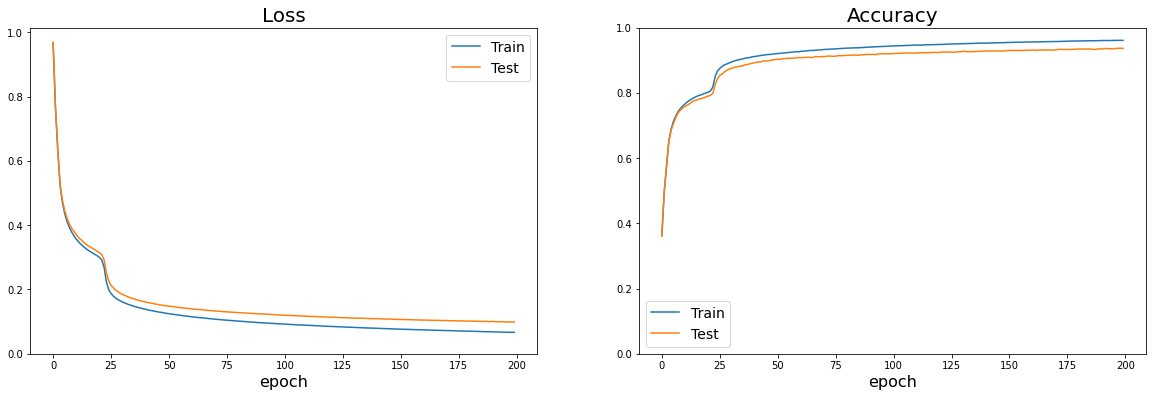

In [16]:
import matplotlib.pyplot as plt

def plot_scores(df: pd.DataFrame):
    """ plot the loss and accuracy """
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(20, 6))

    df.TrainLoss.plot(ax=ax0, label="Train")
    df.TestLoss.plot(ax=ax0, label="Test")
    ax0.set_title("Loss", fontsize=20)
    ax0.set_xlabel("epoch", fontsize=16)
    ax0.set_ylim(0)
    ax0.legend(fontsize=14)

    df.TrainAccuracy.plot(ax=ax1, label="Train")
    df.TestAccuracy.plot(ax=ax1, label="Test")
    ax1.set_title("Accuracy", fontsize=20)
    ax1.set_xlabel("epoch", fontsize=16)
    ax1.set_ylim(0, 1)
    ax1.legend(fontsize=14)

    plt.show()
    
plot_scores(df_scores)

# PyTorch

Let's create the same model using PyTorch

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.tensor(Xtrain), torch.tensor(Ytrain))
train_loader = DataLoader(train_data, batch_size=1000)

test_data = TensorDataset(torch.tensor(Xtest), torch.tensor(Ytest))
test_loader = DataLoader(test_data, batch_size=1000)

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class PYTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.fc1(x.float())
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [19]:
from torch.optim.optimizer import Optimizer
import torch.optim as optim


def train_pytorch_epoch(model: nn.Module, train_loader: DataLoader, optimizer: Optimizer) -> None:
    model.train()
    for ix, (X, Y) in enumerate(train_loader):
        OHY = torch.Tensor(one_hot_encode(Y))
        
        # reset the gradients to zero (dW, db, etc.)
        optimizer.zero_grad()                
        output = model(X)
        
        # FCNN uses SSE Loss (sum square error). In PyTorch the closest is
        # MSE (mean square error) with reduction="sum" rather than "mean"
        # but "sum" doesn't average over the batch size so that is accounted
        # for in score_pytorch and the learning rate
        loss = F.mse_loss(output, OHY, reduction="sum")
        loss.backward()
        optimizer.step()


def score_pytorch(model: nn.Module, X: torch.Tensor, Y: torch.Tensor):
    model.eval()
    with torch.no_grad():
        OHY = torch.Tensor(one_hot_encode(Y))
        output = model(X)
        loss = F.mse_loss(output, OHY, reduction="sum") / X.shape[0]  # account for batch size
        accuracy = get_accuracy(output, Y)
        return loss, accuracy


def fit_pytorch(model: nn.Module, 
                train_loader: DataLoader, 
                test_loader: DataLoader,
                optimizer: Optimizer,
                epochs: int = 100
               ) -> List[Tuple[float, float]]:
    """ fit the PyTorch Model """
    scores = []
    status_template = "EPOCH {:<3}: TRAIN LOSS: {:<6.4f}  ACCURACY: {:<5.3}\tTEST LOSS: {:<6.4f}  ACCURACY: {:<5.3}"
    cell_output = Output()
    display(cell_output)
    
    for epoch in range(epochs):
        train_pytorch_epoch(model, train_loader, optimizer)
        train_score = score_pytorch(model, *train_loader.dataset.tensors)
        test_score = score_pytorch(model, *test_loader.dataset.tensors)
        scores.append((*train_score, *test_score))
        
        with cell_output:
            clear_output(wait=True)
            print(status_template.format(epoch, *train_score, *test_score))
            
    return pd.DataFrame(scores, columns=["TrainLoss", "TrainAccuracy", "TestLoss", "TestAccuracy"], dtype=np.float64)

In [20]:
pytm = PYTModel()

# FCNN uses uses Stochastic Gradient Descent, or SGD in PyTorch
# to make it similar to FCNN the learning rate is divided by 1000
# to account for the averaging accross the batch
optimizer = optim.SGD(pytm.parameters(), lr=1e-5)

df_pytorch_scores = fit_pytorch(pytm, train_loader, test_loader, optimizer, epochs=200)

Output()

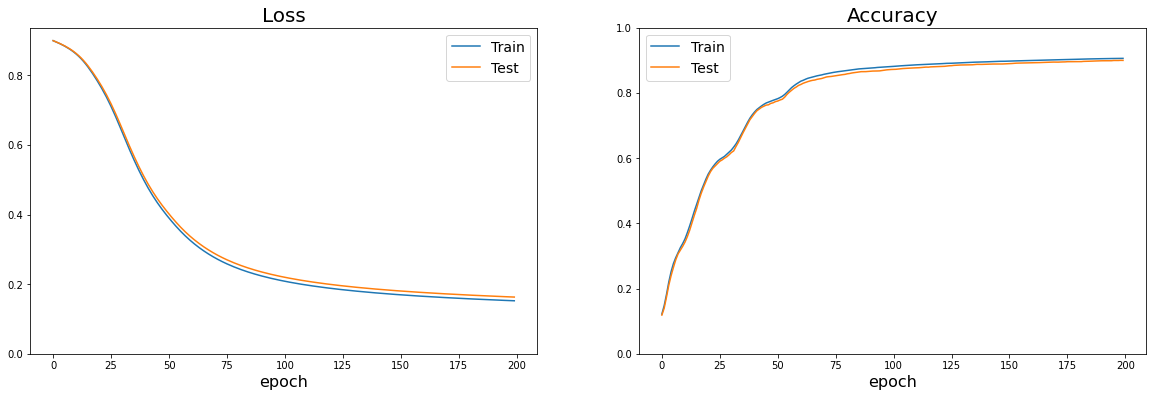

In [21]:
plot_scores(df_pytorch_scores)

The model performs rather well despite being fairly basic. Some things that could be improved:
* Use a more appropriate loss function such as Cross-Entropy Loss
* Use a better optimizer to reduce training time
* Add a convolutional layer

All of these are straight forward with PyTorch. For instance, we can already change the optimizer to `Adadelta` and we can train the model in an order of magnitude fewer epochs.

In [22]:
pytm = PYTModel()

optimizer = optim.Adadelta(pytm.parameters(), lr=0.1)
 
df_pytorch_scores = fit_pytorch(pytm, train_loader, test_loader, optimizer, epochs=25)

Output()

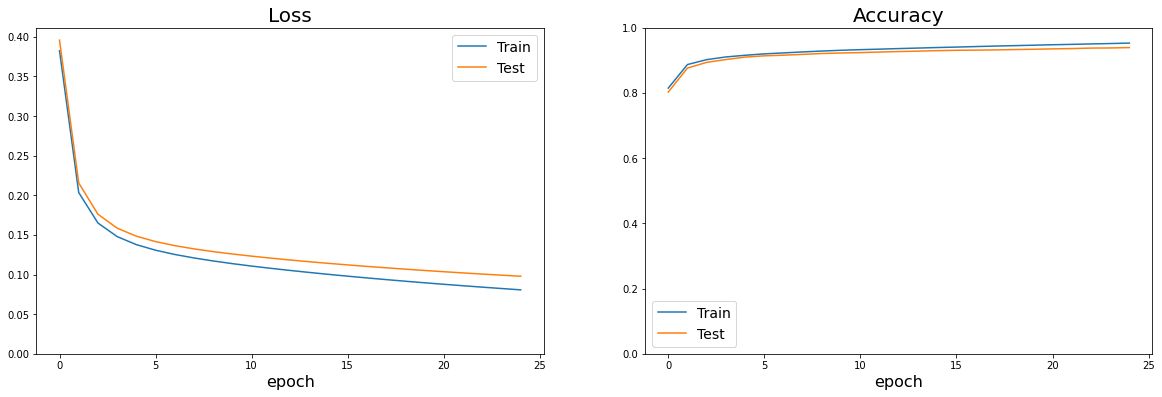

In [23]:
plot_scores(df_pytorch_scores)